In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/aug_xy.zip -d aug_xy

Archive:  gdrive/MyDrive/aug_xy.zip
  inflating: aug_xy/aug_y_slo.npy    
  inflating: aug_xy/aug_x_slo.npy    


(2700, 100, 100, 13) (2700, 100, 100, 9)
(2160, 100, 100, 13) (540, 100, 100, 13) (2160, 100, 100, 9) (540, 100, 100, 9)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  7552        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 64  36928       ['conv2

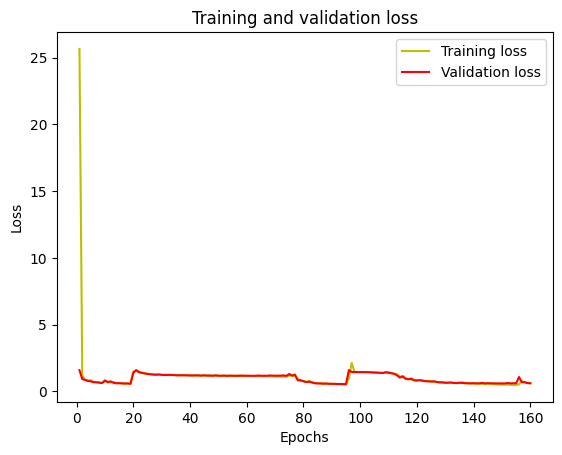

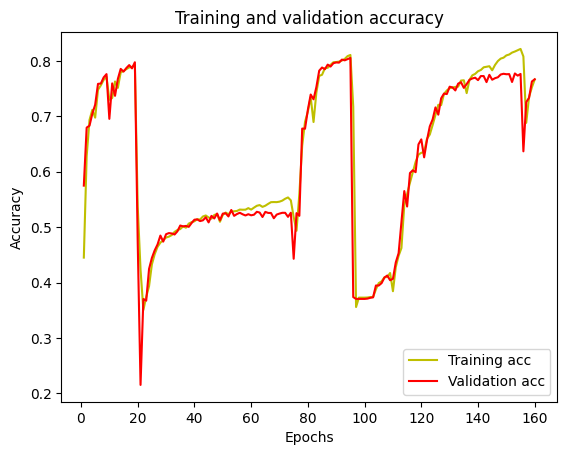

17/17 [==============================] - 1s 61ms/step - loss: 0.6078 - accuracy: 0.7667
Accuracy =  76.66807174682617 %


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Input, Conv2DTranspose, concatenate, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras

IMAGE_SIZE = 100
BATCH_SIZE = 32
N_CLASSES = 9

_x = np.load("aug_xy/aug_x_slo.npy")
_y = np.load("aug_xy/aug_y_slo.npy")
print(_x.shape, _y.shape)
                                                                        
x_train, x_test, y_train, y_test = train_test_split(_x, _y, shuffle=True, random_state=6, test_size=0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

def build_unet(input_shape, num_classes):
    # Input layer
    inputs = Input(input_shape)

    # Contracting path (downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom layer
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Expanding path (upsampling)
    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    up4 = concatenate([up4, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(num_classes, 1, activation='softmax')(conv5)

    model = tf.keras.Model(inputs=inputs, outputs=output)

    return model

model = build_unet(x_train.shape[1:], N_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
history = model.fit(x_train, y_train, epochs=160,
                    validation_data=(x_test, y_test), batch_size=BATCH_SIZE)

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

_, acc = model.evaluate(x_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

In [ ]:
y_pred = model.predict(x_test)
flat_y_pred = []
flat_y_test = []
for (it1, it2) in zip(y_pred, y_test):
  for (i1, i2) in zip(it1, it2):
    for (j1, j2) in zip(i1, i2):
      flat_y_pred.append(np.argmax(j1))
      flat_y_test.append(np.argmax(j2))
flat_y_pred = np.array(flat_y_pred)
flat_y_test = np.array(flat_y_test)
print(flat_y_pred.shape, flat_y_test.shape)

17/17 [==============================] - 1s 53ms/step
(5400000,) (5400000,)


In [ ]:
print(y_pred.shape, y_test.shape)

(540, 100, 100, 9) (540, 100, 100, 9)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(flat_y_test, flat_y_pred)
print(cm)

[[1915113     856    3933       0       0    6346   71062    3071       0]
 [   1688   18140    1663       0       0    4877    5647    5267       0]
 [  28092    1435    7579       1       0    8210   34191   20221       0]
 [    213       1      99       0       0       0     173      85       0]
 [      0       2       1       0       0       2       0       0       0]
 [  18841     708    1520       0       0  506933   97848   73087       0]
 [  56406     316    2821       0       0   94079  939696  269854       0]
 [  14359      92    1898       0       0   64401  339268  752615       1]
 [   1689      92     118       0       0    9748    9977    5665       0]]


In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(flat_y_test, flat_y_pred)
print(cr)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      0.96      0.95   2000381
           1       0.84      0.49      0.62     37282
           2       0.39      0.08      0.13     99729
           3       0.00      0.00      0.00       571
           4       0.00      0.00      0.00         5
           5       0.73      0.73      0.73    698937
           6       0.63      0.69      0.66   1363172
           7       0.67      0.64      0.65   1172634
           8       0.00      0.00      0.00     27289

    accuracy                           0.77   5400000
   macro avg       0.47      0.40      0.41   5400000
weighted avg       0.76      0.77      0.76   5400000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save("the_model")

In [ ]:
!zip -r the_model.zip the_model

  adding: the_model/ (stored 0%)
  adding: the_model/assets/ (stored 0%)
  adding: the_model/saved_model.pb (deflated 89%)
  adding: the_model/fingerprint.pb (stored 0%)
  adding: the_model/variables/ (stored 0%)
  adding: the_model/variables/variables.index (deflated 71%)
  adding: the_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: the_model/keras_metadata.pb (deflated 94%)


In [ ]:
from google.colab import files
files.download("/content/the_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>